# Project description
This dataset contains weather data from 2 regions in Algeria over the period of 3 months and
the goal is to predict if a fire occurred at any day within that period. To create a real-world
scenario, we want to predict if there will be a fire in a future date as provided by the dataset.
The fire prediction is based on weather data collected from the regions.

## Import dataset and visualization

In [1]:
import pandas as pd
import numpy as np
import datetime
from statistics import mean 
from random import choices
from IPython.display import Image
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import datasets
# Train test split
from sklearn.model_selection import train_test_split
# Standardize dataset
from sklearn.preprocessing import StandardScaler
# Backward Feature Selection
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
# PCA
from sklearn.decomposition import PCA
# Nearest mean
from sklearn.neighbors import NearestCentroid
# Perceptron
from sklearn.linear_model import Perceptron
# SVM
from sklearn.svm import SVC
# ANN
from sklearn.neural_network import MLPClassifier
# Metrics
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

In [2]:
# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
    del X_train, y_train
    del X_test, y_test
    print('Clear previously loaded data.')
except:
    pass

origin_data_train = pd.read_csv("algerian_fires_train.csv")
origin_data_test = pd.read_csv("algerian_fires_test.csv")

print('Training data shape: ', origin_data_train.shape)
print('Training labels shape: ', origin_data_train["Classes"].shape)
print('Test data shape: ', origin_data_test.shape)
print('Test labels shape: ', origin_data_test["Classes"].shape)

Training data shape:  (184, 11)
Training labels shape:  (184,)
Test data shape:  (60, 11)
Test labels shape:  (60,)


**Pair plot**

From the pairplot below, I find out that these features varies based on the class of data. 
- FFMC
- DMS
- DC
- ISI
- BUI

Comparing the KDE plot on the diagnol line, we can see the KDEs of the feature above have relatively distinct two peaks that apart from each other. Thus in the later research, I will pay more attention to these features. 

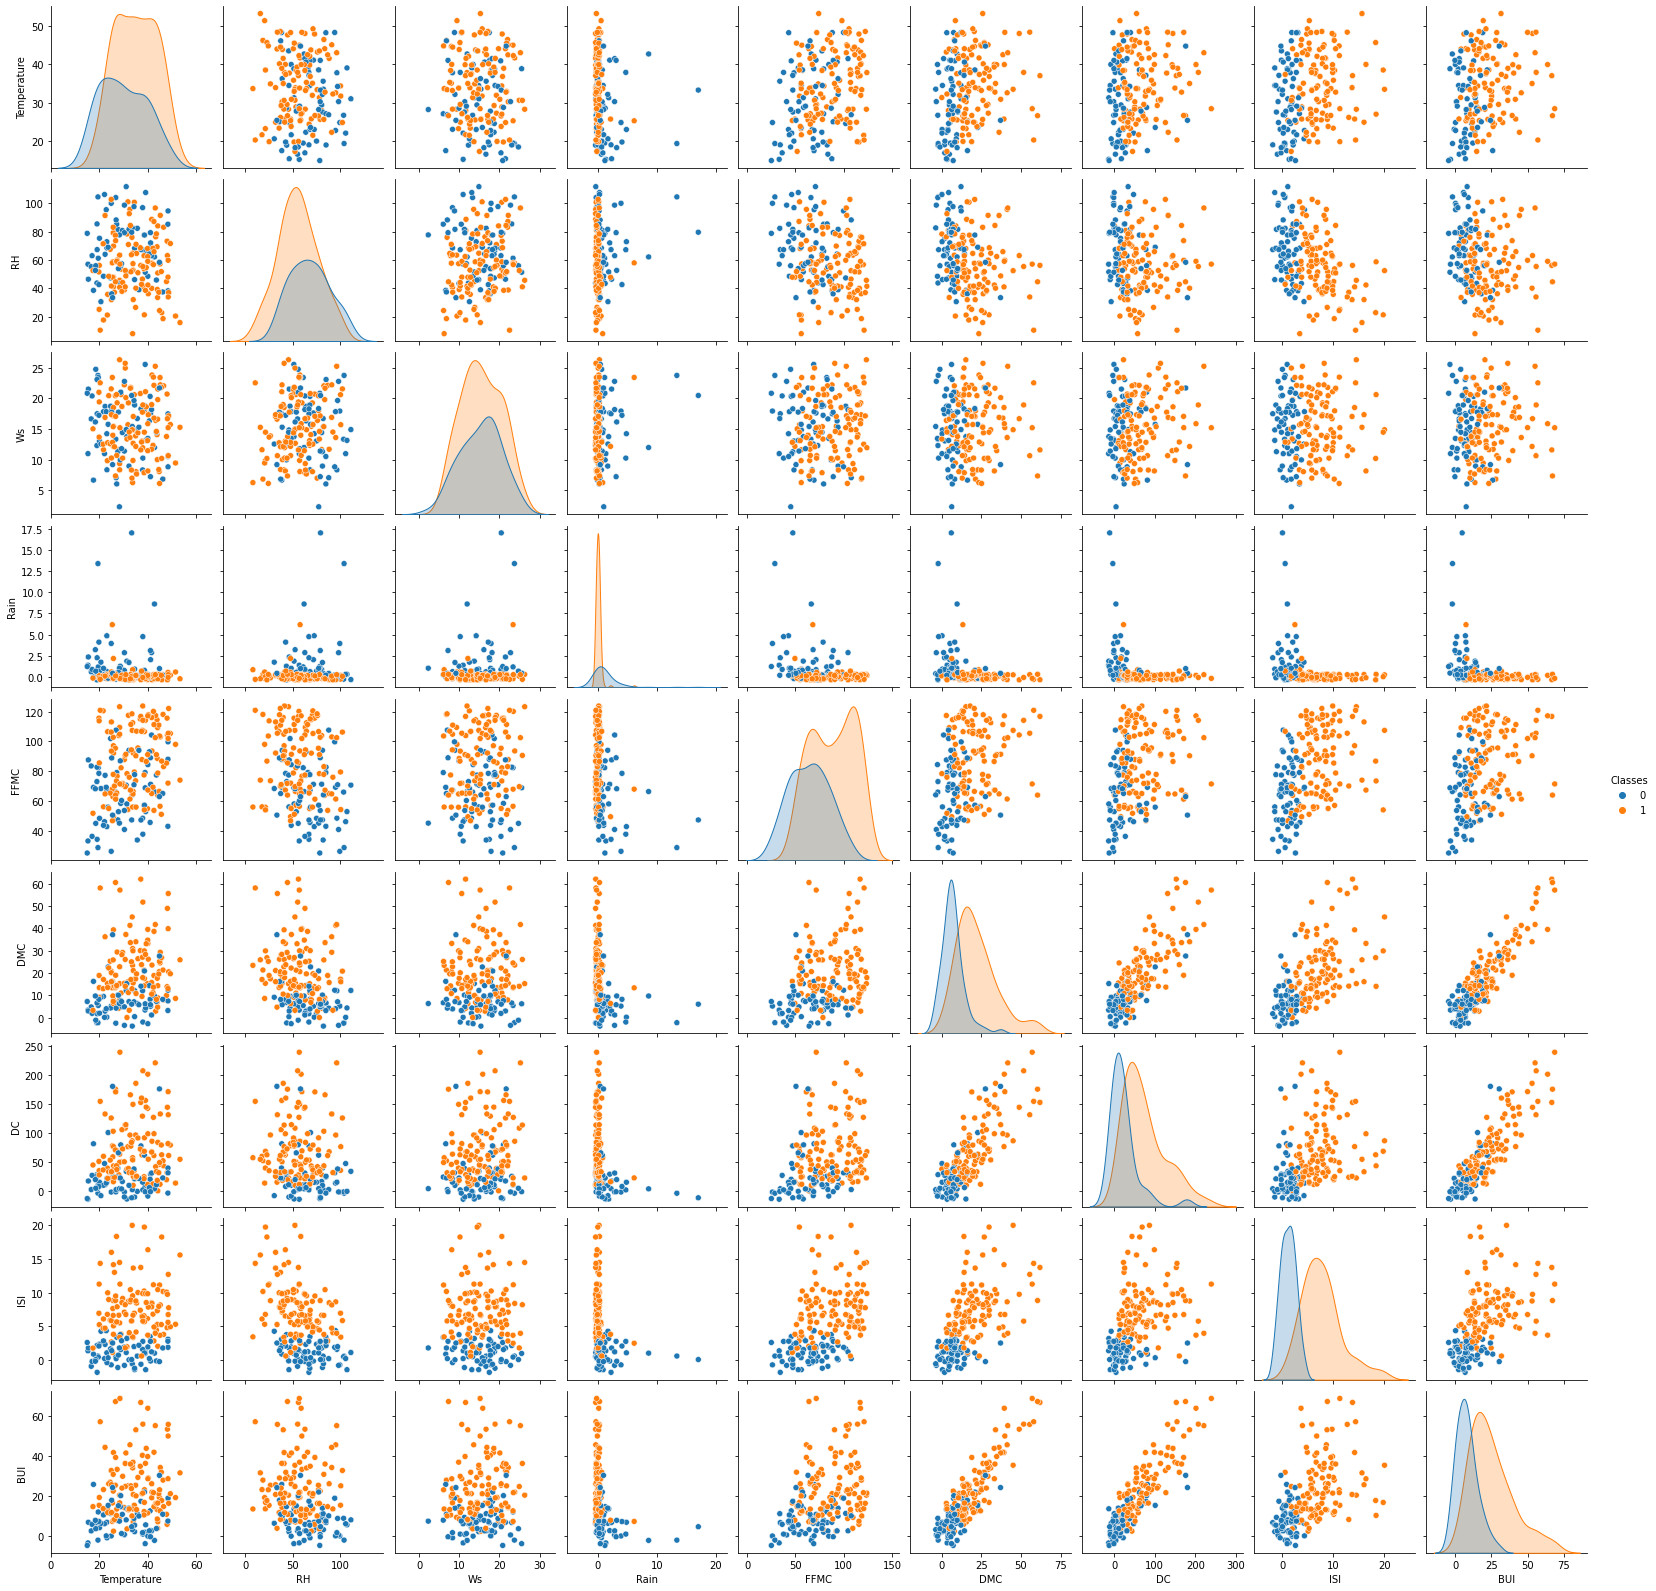

In [3]:
origin_data_train.shape
sns.pairplot(origin_data_train, hue = "Classes")

In [4]:
origin_data_train.describe()

,Temperature,RH,Ws,Rain,FFMC,DMC,DC,ISI,BUI,Classes
count,184.000000,184.000000,184.000000,184.000000,184.000000,184.000000,184.000000,184.000000,184.000000,184.000000
mean,33.038101,60.345678,15.429789,0.623685,79.326887,16.317363,54.867920,5.229877,18.623074,0.625000
std,9.206957,21.636105,5.043585,1.927882,24.657250,13.351472,53.224849,4.551231,15.179727,0.485444
min,14.943358,8.224498,2.284677,-0.340306,25.012416,-3.788684,-13.774588,-1.869065,-4.591342,0.000000
25%,25.675061,44.575487,11.670492,-0.108966,61.005596,6.743533,16.581167,1.753197,7.549093,0.000000
50%,33.248343,58.219381,15.329079,0.186262,77.606042,13.768427,37.793834,4.646720,14.785649,1.000000
75%,40.254673,76.578495,19.046291,0.399674,102.151762,23.447974,78.483567,8.173453,25.499736,1.000000
max,53.226288,111.594365,26.297897,17.019373,123.875341,62.027761,239.290670,20.016175,68.680725,1.000000


In [5]:
# Convert the 'Date' column type from string to datetime 
origin_data_train['Date'] = pd.to_datetime(origin_data_train['Date'], format="%d/%m/%Y")
origin_data_test['Date'] = pd.to_datetime(origin_data_test['Date'], format="%d/%m/%Y")

In [6]:
origin_data_train.head(10)

,Date,Temperature,RH,Ws,Rain,FFMC,DMC,DC,ISI,BUI,Classes
0,2012-06-01,18.952399,43.855865,12.292536,-0.340306,73.063752,-2.371083,28.543573,0.487246,6.225461,0
1,2012-06-01,34.498610,46.230441,14.838211,0.939652,56.027977,0.441002,-10.007636,-1.472158,2.268104,0
2,2012-06-02,15.258665,57.084279,10.968696,1.397913,33.114404,3.389994,-13.774588,1.338737,-3.327908,0
3,2012-06-02,24.847936,99.910000,17.924025,3.958666,26.148986,5.179630,-1.392789,-0.755090,0.131303,0
4,2012-06-03,19.381227,104.398680,23.740540,13.394723,28.658020,-2.247164,-3.432689,0.558249,-1.928471,0
5,2012-06-03,41.100323,72.071701,17.605822,2.046936,71.234188,5.110650,29.392823,-0.182703,2.785474,0
6,2012-06-04,19.038842,67.336851,17.482233,2.273605,34.222983,1.767097,4.310680,-1.869065,6.780638,0
7,2012-06-04,38.808710,66.252407,18.786801,-0.217015,79.137628,3.403384,7.600304,1.212227,2.014532,0
8,2012-06-05,26.742422,103.920124,13.327026,-0.254259,65.985175,-2.474512,-1.149105,0.456845,8.948538,0
9,2012-06-05,40.902608,68.450348,20.315958,0.147903,45.562802,8.227194,20.577706,3.455350,12.660480,0


### Original Dataset

Drop the date columns
* The `Date` column cannot be used as a feature, since its type is datetime and not useful in fire. 

In [7]:
# Original dataset
X_train = origin_data_train.drop(columns = ["Classes", "Date"]).to_numpy()
X_test = origin_data_test.drop(columns = ["Classes", "Date"]).to_numpy()
y_train = origin_data_train["Classes"].to_numpy()
y_test = origin_data_test["Classes"].to_numpy()

# General procedure




## Preprocessing
* Normalization or Standardization
  - Normalize the data when features have different ranges.
  - Standardize the data when we compare the features with different units.  
  We should standardize the data since all features have different units.   
  By standardizing the dataset, we make all features center at 0 with standard deviation of 1.   
  
* Balanced   
  Dataset of this project has 45% "fire" class data and 55% "not fire" class data, which is quite balanced. I decided to not modify the balance of the data. 

### Standardize Dataset

In [8]:
sc_0 = StandardScaler()
sc_0.fit(X_train)
X_train_std = sc_0.transform(X_train)
X_test_std = sc_0.transform(X_test)

## Feature Engineering


### Expansion  
We can create extra features on the whole dataset (training + test) based on the
existing/original ones. The new features can reflect statistics of the original ones such as:

* Average/min/max/median temperature/rain/humidity/wind of the last 2/5/7 days

* Since the dataset is time dependent, we should build the table separately depending on 2/5/7 days prediction. (Three tables in total)

* There are total 4x4=16 additional features in every table.
  
*Cited: EE 559 Project Description*

In [9]:
def expand_table(df_train, df_test, train_test, n_days):
    """
    Parameters : 
    df (dataframe): dataframe be expanded (origin_data_train, origin_data_test)
    train_test (str): "train" or "test", depending on the input dataframe is training or test dataset
    n_days (int): number of days used to conclude the new columns
    """
    start_date_0 = '2012-06-01'
    start_date = '2012-09-01'
    end_date = '2012-09-30'
    
    def last_n_days_df(x, df, n_days, metrics):
        curr_index = df[df == x].index[0]
        temp_df = np.array([])
        for n in range(1, n_days+1):
            if curr_index - 2 >=0:
                temp_df = np.append(temp_df, df.loc[curr_index - 2])
                curr_index -= 2
            else:
                x = None
                return x
        if metric == "avg":
            x = temp_df.mean()
        elif metric == "min": 
            x = temp_df.min()
        elif metric == "max": 
            x = temp_df.max()
        elif metric == "median": 
            x = np.median(temp_df)
        return x
    
    # Generate extra features' columns for train and test table
    if train_test == "train": 
        df = df_train.copy()
        cols = ["Temperature", "RH", "Ws", "Rain"]
        metrics = ["avg", "min", "max", "median"]
        for col in cols:
            for metric in metrics:
                name = metric + "_" + col
                df[name] = df[col].apply(lambda x: last_n_days_df(x, df[col], n_days, metric))

    elif train_test == "test":
        df = df_test.copy()
        test_calc_day = pd.to_datetime(start_date, format="%Y-%m-%d") - pd.Timedelta(days=n_days)
        df_addition = df_train.loc[df_train['Date'] >= test_calc_day]
        df = pd.concat([df_addition, df]).sort_values(by="Date").reset_index(drop=True)
        
        cols = ["Temperature", "RH", "Ws", "Rain"]
        metrics = ["avg", "min", "max", "median"]
        for col in cols:
            for metric in metrics:
                name = metric + "_" + col
                df[name] = df[col].apply(lambda x: last_n_days_df(x, df[col], n_days, metric))
    
    # index the dates for training and test
    # test
    test_start_date = pd.to_datetime(start_date, format="%Y-%m-%d")
    test_end_date = pd.to_datetime(end_date, format="%Y-%m-%d", infer_datetime_format=True)
    mask_test = (df['Date'] >= test_start_date) & (df['Date']<= test_end_date) 
    #train
    train_start_date = pd.to_datetime(start_date_0, infer_datetime_format=True) + pd.Timedelta(days=n_days)
    train_end_date = pd.to_datetime(start_date, infer_datetime_format=True) - pd.Timedelta(days=n_days)
    mask_train = (df['Date'] >= train_start_date) & (df['Date'] < train_end_date)
    
    # Generate final table using mask
    if train_test == "train": 
        df_n_days = df.loc[mask_train].reset_index(drop=True)
    elif train_test == "test":
        df_n_days = df.loc[mask_test].reset_index(drop=True)

    return df_n_days

In [10]:
train_exp_2 = expand_table(origin_data_train, origin_data_test, "train", 2)
train_exp_5 = expand_table(origin_data_train, origin_data_test, "train", 5)
train_exp_7 = expand_table(origin_data_train, origin_data_test, "train", 7)
print("The shape of 2 days training table: ", train_exp_2.shape)
print("The shape of 5 days training table: ", train_exp_5.shape)
print("The shape of 7 days training table: ", train_exp_7.shape)

The shape of 2 days training table:  (176, 27)
The shape of 5 days training table:  (164, 27)
The shape of 7 days training table:  (156, 27)


In [11]:
test_exp_2 = expand_table(origin_data_train, origin_data_test, "test", 2)
test_exp_5 = expand_table(origin_data_train, origin_data_test, "test", 5)
test_exp_7 = expand_table(origin_data_train, origin_data_test, "test", 7)
print("The shape of 2 days test table: ", test_exp_2.shape)
print("The shape of 5 days test table: ", test_exp_5.shape)
print("The shape of 7 days test table: ", test_exp_7.shape)

The shape of 2 days test table:  (60, 27)
The shape of 5 days test table:  (60, 27)
The shape of 7 days test table:  (60, 27)


In [12]:
# test_exp_2.info()

In [13]:
# Expanded dataset (day = 2)
X_train_exp_2 = train_exp_2.drop(columns = ["Classes", "Date"]).to_numpy()
X_test_exp_2 = test_exp_2.drop(columns = ["Classes", "Date"]).to_numpy()
y_train_exp_2 = train_exp_2["Classes"].to_numpy()
y_test_exp_2 = test_exp_2["Classes"].to_numpy()

# Expanded dataset (day = 5)
X_train_exp_5 = train_exp_5.drop(columns = ["Classes", "Date"]).to_numpy()
X_test_exp_5 = test_exp_5.drop(columns = ["Classes", "Date"]).to_numpy()
y_train_exp_5 = train_exp_5["Classes"].to_numpy()
y_test_exp_5 = test_exp_5["Classes"].to_numpy()

# Expanded dataset (day = 7)
X_train_exp_7 = train_exp_7.drop(columns = ["Classes", "Date"]).to_numpy()
X_test_exp_7 = test_exp_7.drop(columns = ["Classes", "Date"]).to_numpy()
y_train_exp_7 = train_exp_7["Classes"].to_numpy()
y_test_exp_7 = test_exp_7["Classes"].to_numpy()

### Standardize Expanded Features

In [14]:
# Standardize the expanded dataset

sc_2 = StandardScaler()
sc_2.fit(X_train_exp_2)
X_train_exp_2_std = sc_2.transform(X_train_exp_2)
X_test_exp_2_std = sc_2.transform(X_test_exp_2)

sc_5 = StandardScaler()
sc_5.fit(X_train_exp_5)
X_train_exp_5_std = sc_5.transform(X_train_exp_5)
X_test_exp_5_std = sc_5.transform(X_test_exp_5)

sc_7 = StandardScaler()
sc_7.fit(X_train_exp_7)
X_train_exp_7_std = sc_7.transform(X_train_exp_7)
X_test_exp_7_std = sc_7.transform(X_test_exp_7)

#### Summary

By expanding the table, we get 16 extra features: 

Average | Min | Max | Median 
--- | --- | --- | --- 
avg_Temperature | min_Temperature | max_Temperature | median_Temperature 
avg_RH | min_RH | max_RH | median_RH 
avg_Ws | min_Ws | max_Ws | median_Ws 
avg_Rain | min_Rain | max_Rain | median_Rain 


In general, we calculate the 16 features based on previous n days (n = 2, 5, 7). This dataset has 2 feature points for each day, since it includes 2 regions. I calculate the average/min/max/median based on n data points of the 2n data points in previous n days. 

For example, n = 2:  

When I calculate the avg_Temperature 

```python
# sudo code
df["avg_temperature"][df["Date"] == '2012-06-03'] 
    = (df["Temperature"][df["Date"] == '2012-06-01'] 
       + df["Temperature"][df["Date"] == '2012-06-02'])/2
```
**Training set**  
After expansion, for the first n days, the expanded features have `Nan` values.   
It's reasonable, since the first day (ex. '2012-06-01') cannot produce the average of last two days due to lack of information. 
For each table, I dropped the first n columns which contains `Nan` values.

Besides, I dropped the last n days in training data as well. The reason is when I generate the test set, I used the last n days data points to compute the avg/min/max/median of the first n days.  

List of training expanded tables:   
* train_exp_2: shape = (176, 27)
* train_exp_5: shape = (164, 27)
* train_exp_7: shape = (156, 27)

 
**Test set**  
I used the last n days data points of training dataset to compute the avg/min/max/median of the first n days.  

No data in test set is dropped. 

List of test expanded tables:   
* test_exp_2: shape = (60, 27)
* test_exp_5: shape = (60, 27)
* test_exp_7: shape = (60, 27)

### Cross Validation

Since the dataset is time dependent, we cannot use the usual random shuffle training-validation split. 
Inside we should split the training dataset into `k` folders depending on the date. 

Normally, we use the previous data to predict data in the future. However, in this dataset case, the data points in the dataset is too few to use this technique. Thus, we will use `k-1` folders contiguous data points as training set to predict the validation set. 

**K-folders Cross validation** 

<div>
<img src="cv_normal.png" width="500"/>
</div>


**Cross Validation for Time Series**

<div>
<img src="cross_validation_time.png" width="500"/>
</div>


source: https://medium.com/@soumyachess1496/cross-validation-in-time-series-566ae4981ce4

For current dataset, I will create 3 folders for the training dataset, each folder contains data in one month.  Besides, I will cutoff the n-days data before each folder, in which n is the number of days used to calculate the n days moving average.   

<div>
<img src="cv_cutoff.jpg" width="500"/>
</div>

For example:  
In the June dataset,   

* The first n days will be cutoff since the first n days has `Nan` values. 

* The last n days should be cutoff as well, since the validation set will use the last n days of June data.   

In the July dataset, 

* The last n days should be cutoff, since the training dataset of August used the last n days of validation set. 


**Folder 1**   
* Training set = June, July
* Validation set = August

In [15]:
def train_cv_1(df, n_days):
    train_end_date = pd.to_datetime('2012-08-01', infer_datetime_format=True) - pd.Timedelta(days=n_days)
    valid_start_date = pd.to_datetime('2012-08-01', infer_datetime_format=True)
    mask_train = (df['Date'] <= train_end_date)
    train_cv = df.loc[mask_train].reset_index(drop=True)
    
    mask_valid = (df['Date'] >= valid_start_date)
    valid_cv = df.loc[mask_valid].reset_index(drop=True)
    
    return train_cv, valid_cv

In [16]:
def train_cv_2(df, n_days):
    train1_end_date = pd.to_datetime('2012-07-01', infer_datetime_format=True) - pd.Timedelta(days=n_days)
    valid_start_date = pd.to_datetime('2012-07-01', infer_datetime_format=True) 
    valid_end_date = pd.to_datetime('2012-08-01', infer_datetime_format=True) - pd.Timedelta(days=n_days)
    train2_start_date = pd.to_datetime('2012-08-01', infer_datetime_format=True)
    
    mask_train = (df['Date'] <= train1_end_date) | (df['Date'] >= train2_start_date)
    train_cv = df.loc[mask_train].reset_index(drop=True)
    
    mask_valid = (df['Date'] >= valid_start_date) & (df['Date'] <= valid_end_date)
    valid_cv = df.loc[mask_valid].reset_index(drop=True)
    
    return train_cv, valid_cv

In [17]:
def train_cv_3(df, n_days):
    train_start_date = pd.to_datetime('2012-07-01', infer_datetime_format=True)
    valid_end_date = pd.to_datetime('2012-07-01', infer_datetime_format=True) - pd.Timedelta(days=n_days)

    mask_train = (df['Date'] >= train_start_date)
    train_cv = df.loc[mask_train].reset_index(drop=True)
    
    mask_valid = (df['Date'] <= valid_end_date)
    valid_cv = df.loc[mask_valid].reset_index(drop=True)
    
    return train_cv, valid_cv

In [18]:
# Split 3 folders
# Folder 1
train_cv_1_2days, valid_cv_1_2days = train_cv_1(train_exp_2, 2)
train_cv_1_5days, valid_cv_1_5days = train_cv_1(train_exp_5, 5)
train_cv_1_7days, valid_cv_1_7days = train_cv_1(train_exp_7, 7)
# Folder 2
train_cv_2_2days, valid_cv_2_2days = train_cv_2(train_exp_2, 2)
train_cv_2_5days, valid_cv_2_5days = train_cv_2(train_exp_5, 5)
train_cv_2_7days, valid_cv_2_7days = train_cv_2(train_exp_7, 7)
# Folder 3
train_cv_3_2days, valid_cv_3_2days = train_cv_3(train_exp_2, 2)
train_cv_3_5days, valid_cv_3_5days = train_cv_3(train_exp_5, 5)
train_cv_3_7days, valid_cv_3_7days = train_cv_3(train_exp_7, 7)

In [19]:
N_days = {
    2: {
        1: (train_cv_1_2days, valid_cv_1_2days),
        2: (train_cv_2_2days, valid_cv_2_2days),
        3: (train_cv_3_2days, valid_cv_3_2days)
    }, 
    5: {
        1: (train_cv_1_5days, valid_cv_1_5days), 
        2: (train_cv_2_5days, valid_cv_2_5days), 
        3: (train_cv_3_5days, valid_cv_3_5days)
    },
    7: {
        1: (train_cv_1_7days, valid_cv_1_7days),
        2: (train_cv_2_7days, valid_cv_2_7days), 
        3: (train_cv_3_7days, valid_cv_3_7days)
    }
}
for n_days, value in N_days.items():
    print("n = {}\n".format(n_days))
    for n_folder, train_val in value.items():
        print("\tFolder = {}".format(n_folder))
        train = train_val[0]
        val = train_val[1]
        print("\t\tTraining set starts from {}, end at {}. ".format(train["Date"][0].date(), 
                                train["Date"][int(train["Date"].count())-1].date()))
        print("\t\tValidation set starts from {}, end at {}. ".format(val["Date"][0].date(), 
                                val["Date"][int(val["Date"].count())-1].date()))

n = 2

	Folder = 1
		Training set starts from 2012-06-03, end at 2012-07-30. 
		Validation set starts from 2012-08-01, end at 2012-08-29. 
	Folder = 2
		Training set starts from 2012-06-03, end at 2012-08-29. 
		Validation set starts from 2012-07-01, end at 2012-07-30. 
	Folder = 3
		Training set starts from 2012-07-01, end at 2012-08-29. 
		Validation set starts from 2012-06-03, end at 2012-06-29. 
n = 5

	Folder = 1
		Training set starts from 2012-06-06, end at 2012-07-27. 
		Validation set starts from 2012-08-01, end at 2012-08-26. 
	Folder = 2
		Training set starts from 2012-06-06, end at 2012-08-26. 
		Validation set starts from 2012-07-01, end at 2012-07-27. 
	Folder = 3
		Training set starts from 2012-07-01, end at 2012-08-26. 
		Validation set starts from 2012-06-06, end at 2012-06-26. 
n = 7

	Folder = 1
		Training set starts from 2012-06-08, end at 2012-07-25. 
		Validation set starts from 2012-08-01, end at 2012-08-24. 
	Folder = 2
		Training set starts from 2012-06-08, end 

In [20]:
train_cv_1_2days.shape

(116, 27)

### Validation set

In [21]:
# n = 2
X_train_cv1_2 = train_cv_1_2days.drop(columns = ["Classes", "Date"]).to_numpy()
X_val_cv1_2 = valid_cv_1_2days.drop(columns = ["Classes", "Date"]).to_numpy()
y_train_cv1_2 = train_cv_1_2days["Classes"].to_numpy()
y_val_cv1_2 = valid_cv_1_2days["Classes"].to_numpy()


In [22]:
# n = 5
X_train_cv1_5 = train_cv_1_5days.drop(columns = ["Classes", "Date"]).to_numpy()
X_val_cv1_5 = valid_cv_1_5days.drop(columns = ["Classes", "Date"]).to_numpy()
y_train_cv1_5 = train_cv_1_5days["Classes"].to_numpy()
y_val_cv1_5 = valid_cv_1_5days["Classes"].to_numpy()


In [23]:
# n = 7

X_train_cv1_7 = train_cv_1_7days.drop(columns = ["Classes", "Date"]).to_numpy()
X_val_cv1_7 = valid_cv_1_7days.drop(columns = ["Classes", "Date"]).to_numpy()
y_train_cv1_7 = train_cv_1_7days["Classes"].to_numpy()
y_val_cv1_7 = valid_cv_1_7days["Classes"].to_numpy()


### Reduction  
The feature space of the original dataset is 10 (D = 10) including the "Date" feature.  
After feature expansion, the expanded dataset has a larger feature space with dimension = 26.  

Large feature space may cause overfitting problems and increase the space and time complexity of computation.  
Thus, we can implement moderate feature reduction techniques to reduce the feature space. 


  >- Measure features correlation
  >- Sequential Feature Selection (forward or backward)
  >- Other methods (starting with Lecture 19, p. 9), Discussion 10, last page)
    * PCA feature selection
    * Fisher

Others

  * Regularization L1 and L2 method (cross validation)
  * Neuron Network
  
Since there are 3 tables with the same dimension (D = 26) after feature expansion, I will use the table expanded by 5-days extra features `train_exp_5` as the example of  feature reduction. 

citation: https://towardsdatascience.com/feature-selection-with-pandas-e3690ad8504b
refered Pearson and Backward selection method.


#### Pearson Features (Correlation)   

Generating a feature correlation matrix, we can see the correlation between each features and the correlation between each feature and feature class.  

It's hard to get some insights from the correlation matrix since it's too tight. Thus, we can view the `Classes` row only and plot the correlation between `Classes` and other features.

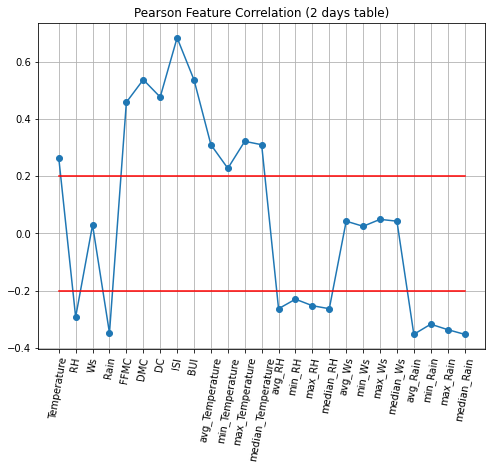

In [24]:
#Using Pearson Correlation
# n_days = 2
cor = train_exp_2.corr()
cor_serie = cor["Classes"].drop(index = "Classes")
cor_x = cor_serie.index
cor_y = cor_serie
plt.figure(figsize=(8,6))
plt.plot(cor_x, cor_y, "o-")
x = np.linspace(0,24,100)
y_1 = 0.2 + x * 0
y_2 = -0.2 + x * 0
plt.plot(x, y_1, "r-")
plt.plot(x, y_2, "r-")
plt.title("Pearson Feature Correlation (2 days table)")
plt.tick_params(axis='x', labelrotation = 80, left=True)
plt.grid()
plt.savefig('pearson_2days.png')

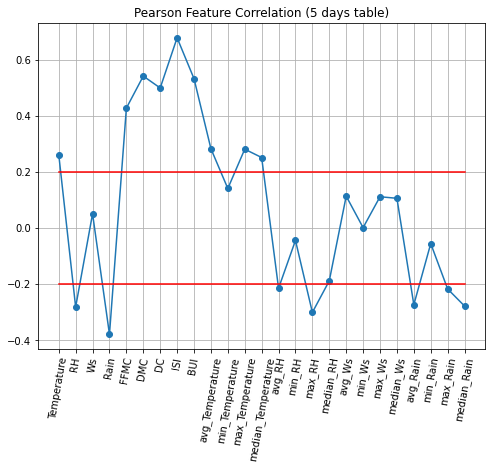

In [25]:
#Using Pearson Correlation
# n_days = 5
cor = train_exp_5.corr()
cor_serie = cor["Classes"].drop(index = "Classes")
cor_x = cor_serie.index
cor_y = cor_serie
plt.figure(figsize=(8,6))
plt.plot(cor_x, cor_y, "o-")
x = np.linspace(0,24,100)
y_1 = 0.2 + x * 0
y_2 = -0.2 + x * 0
plt.plot(x, y_1, "r-")
plt.plot(x, y_2, "r-")
plt.title("Pearson Feature Correlation (5 days table)")
plt.tick_params(axis='x', labelrotation = 80, left=True)
plt.grid()
plt.savefig('pearson_5days.png')

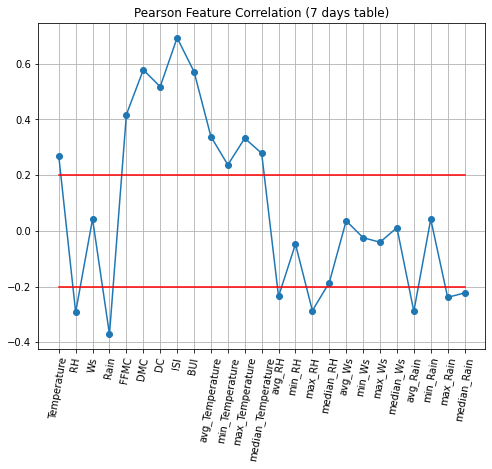

In [26]:
#Using Pearson Correlation
# n_days = 7
cor = train_exp_7.corr()
cor_serie = cor["Classes"].drop(index = "Classes")
cor_x = cor_serie.index
cor_y = cor_serie
plt.figure(figsize=(8,6))
plt.plot(cor_x, cor_y, "o-")
x = np.linspace(0,24,100)
y_1 = 0.2 + x * 0
y_2 = -0.2 + x * 0
plt.plot(x, y_1, "r-")
plt.plot(x, y_2, "r-")
plt.title("Pearson Feature Correlation (7 days table)")
plt.tick_params(axis='x', labelrotation = 80, left=True)
plt.grid()
plt.savefig('pearson_7days.png')

From the plot above, I determined to use the features whose correlation absolute value is higher than 0.2.  

In [27]:
pearson_features = cor["Classes"][abs(cor["Classes"])>0.2].index
pearson_features

Index(['Temperature', 'RH', 'Rain', 'FFMC', 'DMC', 'DC', 'ISI', 'BUI',
       'Classes', 'avg_Temperature', 'min_Temperature', 'max_Temperature',
       'median_Temperature', 'avg_RH', 'max_RH', 'avg_Rain', 'max_Rain',
       'median_Rain'],
      dtype='object')

In [28]:
pearson_features = ['Temperature', 'RH', 'Rain', 'FFMC', 
                    'DMC', 'DC', 'ISI', 'BUI','avg_Temperature', 
                    'min_Temperature', 'max_Temperature',
                    'median_Temperature', 'avg_RH', 'max_RH', 
                    'avg_Rain', 'max_Rain', 'median_Rain']

# Expanded
# n = 2 days
X_train_pear_2 = train_exp_2[pearson_features].to_numpy()
X_test_pear_2 = test_exp_2[pearson_features].to_numpy()
y_train_pear_2 = train_exp_2["Classes"].to_numpy()
y_test_pear_2 = test_exp_2["Classes"].to_numpy()

# std
sc_2 = StandardScaler()
sc_2.fit(X_train_pear_2)
X_train_pear_2_std = sc_2.transform(X_train_pear_2)
X_test_pear_2_std = sc_2.transform(X_test_pear_2)

# n = 5 days
X_train_pear_5 = train_exp_5[pearson_features].to_numpy()
X_test_pear_5 = test_exp_5[pearson_features].to_numpy()
y_train_pear_5 = train_exp_5["Classes"].to_numpy()
y_test_pear_5 = test_exp_5["Classes"].to_numpy()

# std
sc_5 = StandardScaler()
sc_5.fit(X_train_pear_5)
X_train_pear_5_std = sc_5.transform(X_train_pear_5)
X_test_pear_5_std = sc_5.transform(X_test_pear_5)

# n = 7 days
X_train_pear_7 = train_exp_7[pearson_features].to_numpy()
X_test_pear_7 = test_exp_7[pearson_features].to_numpy()
y_train_pear_7 = train_exp_7["Classes"].to_numpy()
y_test_pear_7 = test_exp_7["Classes"].to_numpy()

# std
sc_7 = StandardScaler()
sc_7.fit(X_train_pear_7)
X_train_pear_7_std = sc_7.transform(X_train_pear_7)
X_test_pear_7_std = sc_7.transform(X_test_pear_7)

**Pearson feature selection result**

After pearson feature selection, I got 16 features left whose (absolute) correlation with classification is higher than 0.2. 
```python
['Temperature', 'RH', 'Rain', 'FFMC', 'DMC', 'DC', 'ISI', 'BUI', 'avg_Temperature', 
 'max_Temperature', 'median_Temperature', 'avg_RH', 'max_RH', 'avg_Rain', 'max_Rain', 'median_Rain']
```

#### Backward Feature Selection

1. Choose a significant level (Sign_lvl = 0.05 with a 95% confidence)
2. Fit the full model with all features
3. Consider the feature with the highest p-value > significant level, then go step 4
4. Remove the feature which is under consideration
5. Fit a model without this feature, repeat step 3

source: https://www.youtube.com/watch?v=2Y4PrhMyqX0

In [29]:
sbs_2 = SFS(Perceptron(n_iter_no_change = 40, 
                     eta0 = 0.1), 
          k_features='best', 
          forward=False, 
         floating=False,
         verbose=2, 
         scoring='accuracy')
sbs_2.fit(X_train_exp_2, y_train_exp_2, custom_feature_names=train_exp_2.drop(columns = ["Classes", "Date"]).columns)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:    0.1s finished

[2022-05-03 19:30:17] Features: 24/1 -- score: 0.8073015873015874[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed:    0.1s finished

[2022-05-03 19:30:17] Features: 23/1 -- score: 0.8579365079365079[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  23 out of  23 | elapsed:    0.1s finished

[2022-05-03 19:30:17] Features: 22/1 -- score: 0.8301587301587301[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  

SequentialFeatureSelector(estimator=Perceptron(eta0=0.1, n_iter_no_change=40),
                          forward=False, k_features='best', scoring='accuracy',
                          verbose=2)

In [30]:
sbs_5 = SFS(Perceptron(n_iter_no_change = 40, 
                     eta0 = 0.1), 
          k_features='best', 
          forward=False, 
         floating=False,
         verbose=2, 
         scoring='accuracy')
sbs_5.fit(X_train_exp_5, y_train_exp_5, custom_feature_names=train_exp_5.drop(columns = ["Classes", "Date"]).columns)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:    0.1s finished

[2022-05-03 19:30:24] Features: 24/1 -- score: 0.8181818181818181[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed:    0.1s finished

[2022-05-03 19:30:24] Features: 23/1 -- score: 0.8479166666666667[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  23 out of  23 | elapsed:    0.1s finished

[2022-05-03 19:30:24] Features: 22/1 -- score: 0.8299242424242423[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  

SequentialFeatureSelector(estimator=Perceptron(eta0=0.1, n_iter_no_change=40),
                          forward=False, k_features='best', scoring='accuracy',
                          verbose=2)

In [31]:
sbs_7 = SFS(Perceptron(n_iter_no_change = 40, 
                     eta0 = 0.1), 
          k_features='best', 
          forward=False, 
         floating=False,
         verbose=2, 
         scoring='accuracy')
sbs_7.fit(X_train_exp_7, y_train_exp_7, 
        custom_feature_names=train_exp_7.drop(columns = ["Classes", "Date"]).columns)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:    0.1s finished

[2022-05-03 19:30:33] Features: 24/1 -- score: 0.8522177419354838[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed:    0.1s finished

[2022-05-03 19:30:33] Features: 23/1 -- score: 0.8264112903225806[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  23 out of  23 | elapsed:    0.1s finished

[2022-05-03 19:30:33] Features: 22/1 -- score: 0.8393145161290322[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  

SequentialFeatureSelector(estimator=Perceptron(eta0=0.1, n_iter_no_change=40),
                          forward=False, k_features='best', scoring='accuracy',
                          verbose=2)

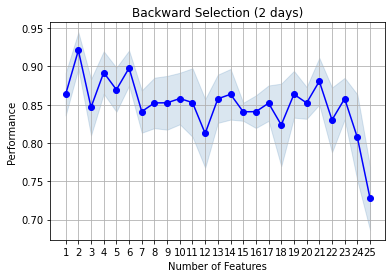

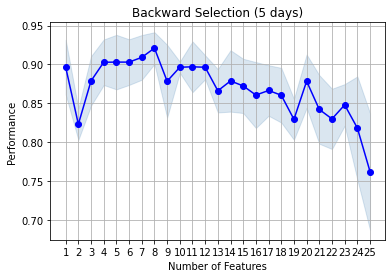

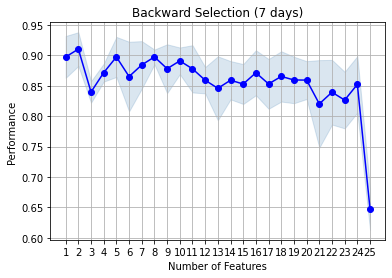

In [32]:
plot_sfs(sbs_2.get_metric_dict(), kind = "std_err")
plt.title("Backward Selection (2 days)")
plt.grid()
plt.savefig("back_select_2days.png")
plt.show()

plot_sfs(sbs_5.get_metric_dict(), kind = "std_err")
plt.title("Backward Selection (5 days)")
plt.grid()
plt.savefig("back_select_5days.png")
plt.show()

plot_sfs(sbs_7.get_metric_dict(), kind = "std_err")
plt.title("Backward Selection (7 days)")
plt.grid()
plt.savefig("back_select_7days.png")
plt.show()

#### PCA Feature Selection   

We can also use PCA feature selection to find the features which is responsible for larger partition of variance. 

First we can fit the PCA constructor with full model (all features). 

source: https://stackabuse.com/implementing-pca-in-python-with-scikit-learn/

##### Without Cross Validation

**n = 2**

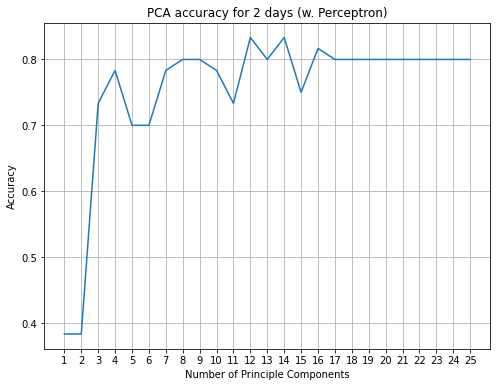

In [33]:
accuracy_lst_pca = []
for n_feature in range(1, len(X_train_exp_2[0])+1):
    pca = PCA(n_components=n_feature)
    X_train_pca = pca.fit_transform(X_train_exp_2)
    X_test_pca = pca.transform(X_test_exp_2)
    classifier = Perceptron(n_iter_no_change=40, eta0=0.1)
    classifier.fit(X_train_pca, y_train_exp_2)
    y_pred = classifier.predict(X_test_pca)
    accuracy_lst_pca.append(accuracy_score(y_test_exp_2, y_pred))

num_features = [x for x in range(1, len(X_train_exp_2[0])+1)]
plt.figure(figsize=(8, 6))
plt.plot(num_features, accuracy_lst_pca)
plt.xticks(num_features)
plt.xlabel("Number of Principle Components")
plt.ylabel("Accuracy")
plt.title("PCA accuracy for 2 days (w. Perceptron)")
plt.grid()
plt.savefig("PCA_2days")

In [34]:
print("The highest accuracy for perceptron method using PCA \n\twithout CV for 5 days is ", 
      round(max(accuracy_lst_pca), 4) * 100, "%")

The highest accuracy for perceptron method using PCA 
	without CV for 5 days is  83.33 %


**n = 5**

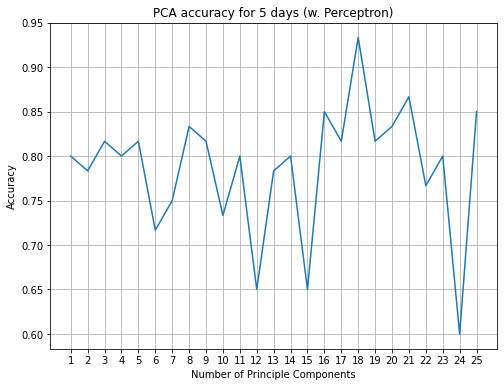

In [35]:
accuracy_lst_pca = []
for n_feature in range(1, len(X_train_exp_5[0])+1):
    pca = PCA(n_components=n_feature)
    X_train_pca = pca.fit_transform(X_train_exp_5)
    X_test_pca = pca.transform(X_test_exp_5)
    classifier = Perceptron(n_iter_no_change=40, eta0=0.1)
    classifier.fit(X_train_pca, y_train_exp_5)
    y_pred = classifier.predict(X_test_pca)
    accuracy_lst_pca.append(accuracy_score(y_test_exp_5, y_pred))

num_features = [x for x in range(1, len(X_train_exp_5[0])+1)]
plt.figure(figsize=(8, 6))
plt.plot(num_features, accuracy_lst_pca)
plt.xticks(num_features)
plt.xlabel("Number of Principle Components")
plt.ylabel("Accuracy")
plt.title("PCA accuracy for 5 days (w. Perceptron)")
plt.grid()
plt.savefig("PCA_5days")

In [36]:
print("The highest accuracy for perceptron method using PCA \n\twithout CV for 5 days is ", 
      round(max(accuracy_lst_pca), 4) * 100, "%")

The highest accuracy for perceptron method using PCA 
	without CV for 5 days is  93.33 %


**n = 7**

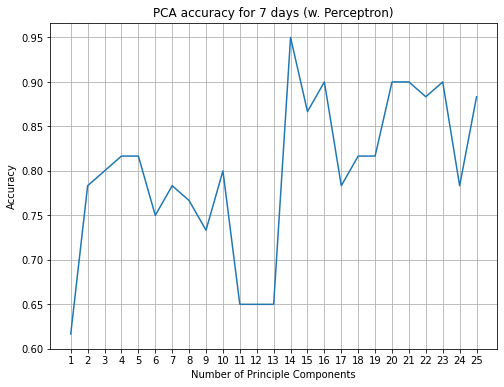

In [37]:
accuracy_lst_pca = []
for n_feature in range(1, len(X_train_exp_7[0])+1):
    pca = PCA(n_components=n_feature)
    X_train_pca = pca.fit_transform(X_train_exp_7)
    X_test_pca = pca.transform(X_test_exp_7)
    classifier = Perceptron(n_iter_no_change=40, eta0=0.1)
    classifier.fit(X_train_pca, y_train_exp_7)
    y_pred = classifier.predict(X_test_pca)
    accuracy_lst_pca.append(accuracy_score(y_test_exp_7, y_pred))

num_features = [x for x in range(1, len(X_train_exp_7[0])+1)]
plt.figure(figsize=(8, 6))
plt.plot(num_features, accuracy_lst_pca)
plt.xticks(num_features)
plt.xlabel("Number of Principle Components")
plt.ylabel("Accuracy")
plt.title("PCA accuracy for 7 days (w. Perceptron)")
plt.grid()
plt.savefig("PCA_7days")

In [38]:
print("The highest accuracy for perceptron method using PCA \n\twithout CV for 5 days is ", 
      round(max(accuracy_lst_pca), 4) * 100, "%")

The highest accuracy for perceptron method using PCA 
	without CV for 5 days is  95.0 %


##### With Cross validation

**n = 2**

In [39]:
def avg_accuracy_2days(N_days_dict, n_day):
    
    avg_accuracy_lst_pca = []
    f_score_lst_pca = []
    for n_feature in range(1, len(X_train_exp_2[0])+1):
        f_score = []
        accuracy = []
        for folder in range(1, 4):
            # Initialize the training model
            pca = PCA(n_components=n_feature)
            
            # Fit the Training data
            train_df = N_days_dict[n_day][folder][0]
            valid_df = N_days_dict[n_day][folder][1]

            # Original dataset
            X_train = train_df.drop(columns = ["Classes", "Date"]).to_numpy()
            X_test = valid_df.drop(columns = ["Classes", "Date"]).to_numpy()
            y_train = train_df["Classes"].to_numpy()
            y_test = valid_df["Classes"].to_numpy()

            X_train_pca = pca.fit_transform(X_train_exp_2)
            X_test_pca = pca.transform(X_test_exp_2)
            
            classifier = Perceptron(n_iter_no_change=40, eta0=0.1)
            classifier.fit(X_train_pca, y_train_exp_2)
            
            # Predict the test set
            y_predict_percp = classifier.predict(X_test_pca)
            f1_sco_percp = f1_score(y_test_exp_2, y_predict_percp)
            accuracy_percp = accuracy_score(y_test_exp_2, y_predict_percp)
            
            f_score.append(f1_sco_percp)
            accuracy.append(accuracy_percp)
#             print("\tFolder {}".format(folder))
#             print("\t\tF1 score of Perceptron method: ", round(f1_sco_percp * 10**2, 2), "%")
#             print("\t\tAccuracy of Perceptron method: ", round(accuracy_percp * 10**2, 2), "%")

        avg_accuracy_lst_pca.append(mean(accuracy))
        f_score_lst_pca.append(mean(f_score))
        
    return avg_accuracy_lst_pca, f_score_lst_pca

In [40]:
avg_accuracy_2 = avg_accuracy_2days(N_days, 2)[0]
avg_f_score_2 = avg_accuracy_2days(N_days, 2)[1]

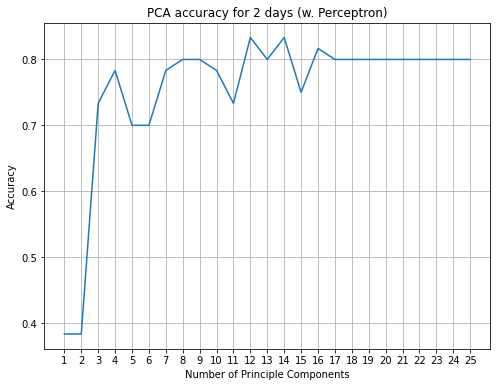

In [41]:
num_features = [x for x in range(1, len(X_train_exp_2[0])+1)]
plt.figure(figsize=(8, 6))
plt.plot(num_features, avg_accuracy_2)
plt.xticks(num_features)
plt.xlabel("Number of Principle Components")
plt.ylabel("Accuracy")
plt.title("PCA accuracy for 2 days (w. Perceptron)")
plt.grid()
plt.savefig("PCA_2days")

In [42]:
print("The highest accuracy for perceptron method using PCA for 2 days is ", round(max(avg_accuracy_2), 4) * 100, "%")
print("The highest f_score for perceptron method using PCA for 2 days is ", round(max(avg_f_score_2), 4) * 100, "%")

The highest accuracy for perceptron method using PCA for 2 days is  83.33 %
The highest f_score for perceptron method using PCA for 2 days is  77.27000000000001 %


**n = 5**

In [43]:
def avg_accuracy_5days(N_days_dict, n_day):
    
    avg_accuracy_lst_pca = []
    f_score_lst_pca = []
    for n_feature in range(1, len(X_train_exp_5[0])+1):
        f_score = []
        accuracy = []
        for folder in range(1, 4):
            # Initialize the training model
            pca = PCA(n_components=n_feature)
            
            # Fit the Training data
            train_df = N_days_dict[n_day][folder][0]
            valid_df = N_days_dict[n_day][folder][1]

            # Original dataset
            X_train = train_df.drop(columns = ["Classes", "Date"]).to_numpy()
            X_test = valid_df.drop(columns = ["Classes", "Date"]).to_numpy()
            y_train = train_df["Classes"].to_numpy()
            y_test = valid_df["Classes"].to_numpy()

            X_train_pca = pca.fit_transform(X_train_exp_5)
            X_test_pca = pca.transform(X_test_exp_5)
            
            classifier = Perceptron(n_iter_no_change=40, eta0=0.1)
            classifier.fit(X_train_pca, y_train_exp_5)
            
            # Predict the test set
            y_predict_percp = classifier.predict(X_test_pca)
            f1_sco_percp = f1_score(y_test_exp_5, y_predict_percp)
            accuracy_percp = accuracy_score(y_test_exp_5, y_predict_percp)
            
            f_score.append(f1_sco_percp)
            accuracy.append(accuracy_percp)
#             print("\tFolder {}".format(folder))
#             print("\t\tF1 score of Perceptron method: ", round(f1_sco_percp * 10**2, 2), "%")
#             print("\t\tAccuracy of Perceptron method: ", round(accuracy_percp * 10**2, 2), "%")

        avg_accuracy_lst_pca.append(mean(accuracy))
        f_score_lst_pca.append(mean(f_score))

        
    return avg_accuracy_lst_pca, f_score_lst_pca

In [44]:
avg_accuracy_5 = avg_accuracy_5days(N_days, 5)[0]
avg_f_score_5 = avg_accuracy_5days(N_days, 5)[1]

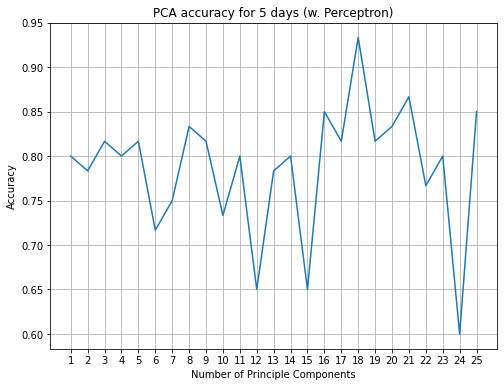

In [45]:
num_features = [x for x in range(1, len(X_train_exp_5[0])+1)]
plt.figure(figsize=(8, 6))
plt.plot(num_features, avg_accuracy_5)
plt.xticks(num_features)
plt.xlabel("Number of Principle Components")
plt.ylabel("Accuracy")
plt.title("PCA accuracy for 5 days (w. Perceptron)")
plt.grid()
plt.savefig("PCA_5days")

In [46]:
print("The highest accuracy for perceptron method using PCA for 5 days is ", round(max(avg_accuracy_5), 4) * 100, "%")
print("The highest f_score for perceptron method using PCA for 5 days is ", round(max(avg_f_score_5), 4) * 100, "%")

The highest accuracy for perceptron method using PCA for 5 days is  93.33 %
The highest f_score for perceptron method using PCA for 5 days is  90.91 %


**n = 7**

In [47]:
def avg_accuracy(N_days_dict, n_day):
    
    avg_accuracy_lst_pca = []
    f_score_lst_pca = []
    for n_feature in range(1, len(X_train_exp_7[0])+1):
        f_score = []
        accuracy = []
        for folder in range(1, 4):
            # Initialize the training model
            pca = PCA(n_components=n_feature)
            
            # Fit the Training data
            train_df = N_days_dict[n_day][folder][0]
            valid_df = N_days_dict[n_day][folder][1]

            # Original dataset
            X_train = train_df.drop(columns = ["Classes", "Date"]).to_numpy()
            X_test = valid_df.drop(columns = ["Classes", "Date"]).to_numpy()
            y_train = train_df["Classes"].to_numpy()
            y_test = valid_df["Classes"].to_numpy()

            X_train_pca = pca.fit_transform(X_train_exp_7)
            X_test_pca = pca.transform(X_test_exp_7)
            
            classifier = Perceptron(n_iter_no_change=40, eta0=0.1)
            classifier.fit(X_train_pca, y_train_exp_7)
            
            # Predict the test set
            y_predict_percp = classifier.predict(X_test_pca)
            f1_sco_percp = f1_score(y_test_exp_7, y_predict_percp)
            accuracy_percp = accuracy_score(y_test_exp_7, y_predict_percp)
            
            f_score.append(f1_sco_percp)
            accuracy.append(accuracy_percp)
#             print("\tFolder {}".format(folder))
#             print("\t\tF1 score of Perceptron method: ", round(f1_sco_percp * 10**2, 2), "%")
#             print("\t\tAccuracy of Perceptron method: ", round(accuracy_percp * 10**2, 2), "%")

        avg_accuracy_lst_pca.append(mean(accuracy))
        f_score_lst_pca.append(mean(f_score))

        
    return avg_accuracy_lst_pca, f_score_lst_pca

In [48]:
avg_accuracy_7 = avg_accuracy(N_days, 7)[0]
avg_f_score_7 = avg_accuracy(N_days, 7)[1]

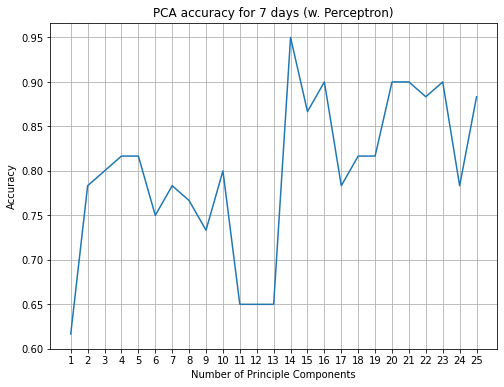

In [49]:
num_features = [x for x in range(1, len(X_train_exp_7[0])+1)]
plt.figure(figsize=(8, 6))
plt.plot(num_features, avg_accuracy_7)
plt.xticks(num_features)
plt.xlabel("Number of Principle Components")
plt.ylabel("Accuracy")
plt.title("PCA accuracy for 7 days (w. Perceptron)")
plt.grid()
plt.savefig("PCA_7days")

In [50]:
print("The highest accuracy for perceptron method using PCA for 7 days is ", round(max(avg_accuracy_7), 4) * 100, "%")
print("The highest f_score for perceptron method using PCA for 7 days is ", round(max(avg_f_score_7), 4) * 100, "%")

The highest accuracy for perceptron method using PCA for 7 days is  95.0 %
The highest f_score for perceptron method using PCA for 7 days is  93.88 %


# Trivial System

A system that outputs class assignments (S1, S2) at random with probability N1/N and N2/N, respectively, 𝑁' is the population of data points with class label Si, and N is the total population of data points, all based on the training set.

## Class Probability and Predict

**On validation set 1**

In [51]:
N = train_cv_1_2days.shape[0]
N_1 = train_cv_1_2days[origin_data_train["Classes"] == 0].shape[0]
N_2 = train_cv_1_2days[origin_data_train["Classes"] == 1].shape[0]
p_1 = N_1/N
p_2 = N_2/N
N_test = valid_cv_1_2days.shape[0]
classes = [0, 1]
prob = [p_1, p_2]
y_test = valid_cv_1_2days["Classes"]
predict = [choices(classes, prob)[0] for n in range(N_test)]

C:\Users\youun\AppData\Local\Temp\ipykernel_28460\1882538453.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  N_1 = train_cv_1_2days[origin_data_train["Classes"] == 0].shape[0]
C:\Users\youun\AppData\Local\Temp\ipykernel_28460\1882538453.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  N_2 = train_cv_1_2days[origin_data_train["Classes"] == 1].shape[0]


In [52]:
f1_sco = f1_score(y_test, predict)
accuracy_1 = accuracy_score(y_test, predict)
print("F1 score of trivial method: ", round(f1_sco * 10**2, 2), "%")
print("Accuracy of trivial method: ", round(accuracy_1 * 10**2, 2), "%")
print("Confusion Matrix: \n", confusion_matrix(y_test, predict))

F1 score of trivial method:  64.1 %
Accuracy of trivial method:  51.72 %
Confusion Matrix: 
 [[ 5  4]
 [24 25]]


**On test set**

In [53]:
N = origin_data_train.shape[0]
N_1 = origin_data_train[origin_data_train["Classes"] == 0].shape[0]
N_2 = origin_data_train[origin_data_train["Classes"] == 1].shape[0]
p_1 = N_1/N
p_2 = N_2/N
N_test = origin_data_test.shape[0]
y_test = origin_data_test["Classes"]
classes = [0, 1]
prob = [p_1, p_2]
print(N_1)

69


In [57]:
predict = [choices(classes, prob)[0] for n in range(N_test)]

In [58]:
f1_sco = f1_score(y_test, predict)
accuracy_1 = accuracy_score(y_test, predict)
print("F1 score of trivial method: ", round(f1_sco * 10**2, 2), "%")
print("Accuracy of trivial method: ", round(accuracy_1 * 10**2, 2), "%")
print("Confusion Matrix: \n", confusion_matrix(y_test, predict))

F1 score of trivial method:  47.46 %
Accuracy of trivial method:  48.33 %
Confusion Matrix: 
 [[15 22]
 [ 9 14]]


## Classifier Accuracy

In [59]:
y_test = origin_data_test["Classes"]

In [60]:
f1_sco = f1_score(y_test, predict)
accuracy_1 = accuracy_score(y_test, predict)
print("F1 score of trivial method: ", round(f1_sco * 10**2, 2), "%")
print("Accuracy of trivial method: ", round(accuracy_1 * 10**2, 2), "%")
print("Confusion Matrix: \n", confusion_matrix(y_test, predict))

F1 score of trivial method:  47.46 %
Accuracy of trivial method:  48.33 %
Confusion Matrix: 
 [[15 22]
 [ 9 14]]


## Summary

Using the Trivial System, we can achieve an predicting accuracy of 48.33 %  

# Nearest Mean System

1. Find the mean of each class ("fire", "not fire") in the training set
2. Calculate the distance between test points each class mean
3. The class of shorter distance determine the testing point's class
4. Calculate the classifier accuracy

Note: In the feature space, the date column should be expanded to three columns ("day", "month", "year"). Since the data is in the period from June 2012 to September 2012, we can drop the year column. 

## Training Data

In [61]:
def nearest_metric(X_train, y_train, X_test, y_test):
    # Initialize the training model
    clf = NearestCentroid()
    # Fit the Training data
    clf.fit(X_train, y_train)
    # Predict the test set
    y_predict_Nearest_Mean = clf.predict(X_test)
    f1_sco_Nearest = f1_score(y_test, 
                              y_predict_Nearest_Mean)
    accuracy_Nearest = accuracy_score(y_test, 
                                      y_predict_Nearest_Mean)
    print("Accuracy of Nearest Mean method: ", 
          round(accuracy_Nearest * 10**2, 2), "%")
    print("F1 score of Nearest Mean method: ", 
          round(f1_sco_Nearest * 10**2, 2), "%")
    print("Confusion Matrix: \n", 
          confusion_matrix(y_test, y_predict_Nearest_Mean))

**On validation set**

In [62]:
nearest_metric(X_train_cv1_2, y_train_cv1_2, 
               X_val_cv1_2, y_val_cv1_2)

Accuracy of Nearest Mean method:  89.66 %
F1 score of Nearest Mean method:  94.0 %
Confusion Matrix: 
 [[ 5  4]
 [ 2 47]]


In [63]:
nearest_metric(X_train_cv1_5, y_train_cv1_5, 
               X_val_cv1_5, y_val_cv1_5)

Accuracy of Nearest Mean method:  88.46 %
F1 score of Nearest Mean method:  93.18 %
Confusion Matrix: 
 [[ 5  3]
 [ 3 41]]


In [64]:
nearest_metric(X_train_cv1_7, y_train_cv1_7, 
               X_val_cv1_7, y_val_cv1_7)

Accuracy of Nearest Mean method:  89.58 %
F1 score of Nearest Mean method:  93.83 %
Confusion Matrix: 
 [[ 5  3]
 [ 2 38]]


## Non Standardized

**Original dataset**

In [65]:
nearest_metric(X_train, y_train, X_test, y_test)

Accuracy of Nearest Mean method:  78.33 %
F1 score of Nearest Mean method:  62.86 %
Confusion Matrix: 
 [[36  1]
 [12 11]]


**n = 2 days**

In [66]:
nearest_metric(X_train_exp_2, y_train_exp_2, 
               X_test_exp_2, y_test_exp_2)

Accuracy of Nearest Mean method:  76.67 %
F1 score of Nearest Mean method:  61.11 %
Confusion Matrix: 
 [[35  2]
 [12 11]]


**n = 5 days**

In [67]:
nearest_metric(X_train_exp_5, y_train_exp_5, 
               X_test_exp_5, y_test_exp_5)

Accuracy of Nearest Mean method:  78.33 %
F1 score of Nearest Mean method:  64.86 %
Confusion Matrix: 
 [[35  2]
 [11 12]]


**n = 7 days**

In [68]:
nearest_metric(X_train_exp_7, y_train_exp_7, 
               X_test_exp_7, y_test_exp_7)

Accuracy of Nearest Mean method:  81.67 %
F1 score of Nearest Mean method:  70.27 %
Confusion Matrix: 
 [[36  1]
 [10 13]]


## Standardized Data

**Original dataset**

In [69]:
nearest_metric(X_train_std, y_train, 
               X_test_std, y_test)

Accuracy of Nearest Mean method:  81.67 %
F1 score of Nearest Mean method:  70.27 %
Confusion Matrix: 
 [[36  1]
 [10 13]]


**n = 2 days**

In [70]:
nearest_metric(X_train_exp_2_std, y_train_exp_2, 
               X_test_exp_2_std, y_test_exp_2)

Accuracy of Nearest Mean method:  75.0 %
F1 score of Nearest Mean method:  61.54 %
Confusion Matrix: 
 [[33  4]
 [11 12]]


**n = 5 days**

In [71]:
nearest_metric(X_train_exp_5_std, y_train_exp_5, 
               X_test_exp_5_std, y_test_exp_5)

Accuracy of Nearest Mean method:  70.0 %
F1 score of Nearest Mean method:  50.0 %
Confusion Matrix: 
 [[33  4]
 [14  9]]


**n = 7 days**

In [72]:
nearest_metric(X_train_exp_7_std, y_train_exp_7, 
               X_test_exp_7_std, y_test_exp_7)

Accuracy of Nearest Mean method:  76.67 %
F1 score of Nearest Mean method:  63.16 %
Confusion Matrix: 
 [[34  3]
 [11 12]]


In [73]:
def avg_accuracy_ndays(N_days_dict, n_day):
    
    accuracy = []
    f_score = []
    
    for folder in range(1, 4):
        # Initialize the training model
        nearest_clf = NearestCentroid()
            
        # Fit the Training data
        train_df = N_days_dict[n_day][folder][0]
        valid_df = N_days_dict[n_day][folder][1]

        # Original dataset
        X_train = train_df.drop(columns = ["Classes", "Date"]).to_numpy()
        X_test = valid_df.drop(columns = ["Classes", "Date"]).to_numpy()
        y_train = train_df["Classes"].to_numpy()
        y_test = valid_df["Classes"].to_numpy()

        nearest_clf.fit(X_train, y_train)
            
        # Predict the test set
        y_predict_Nearest = nearest_clf.predict(X_test)
        f1_sco_Nearest = f1_score(y_test, y_predict_Nearest)
        accuracy_Nearest = accuracy_score(y_test, y_predict_Nearest)

        f_score.append(f1_sco_Nearest)
        accuracy.append(accuracy_Nearest)
        
    return mean(accuracy), mean(f_score)

In [74]:
avg_accuracy_7 = avg_accuracy_ndays(N_days, 7)[0]
avg_f_score_7 = avg_accuracy_ndays(N_days, 7)[1]

In [75]:
print("The highest accuracy for perceptron method using PCA for 7 days is ", round(avg_accuracy_7, 4) * 100, "%")
print("The highest f_score for perceptron method using PCA for 7 days is ", round(avg_f_score_7, 4) * 100, "%")

The highest accuracy for perceptron method using PCA for 7 days is  80.33 %
The highest f_score for perceptron method using PCA for 7 days is  73.74000000000001 %


In [76]:
def avg_error_rate(N_days_dict, n_day):
    f_score = []
    accuracy = []
    for folder in range(1, 4):
        # Initialize the training model
        clf = NearestCentroid()
        # Fit the Training data
        train_df = N_days_dict[n_day][folder][0]
        valid_df = N_days_dict[n_day][folder][1]
        
        # Original dataset
        X_train = train_df.drop(columns = ["Classes", "Date"]).to_numpy()
        X_test = valid_df.drop(columns = ["Classes", "Date"]).to_numpy()
        y_train = train_df["Classes"].to_numpy()
        y_test = valid_df["Classes"].to_numpy()
        
        clf.fit(X_train, y_train)
        
        # Predict the test set
        y_predict_Nearest_Mean = clf.predict(X_test)
        f1_sco_Nearest = f1_score(y_test, y_predict_Nearest_Mean)
        accuracy_Nearest = accuracy_score(y_test, y_predict_Nearest_Mean)
        f_score.append(f1_sco_Nearest)
        accuracy.append(accuracy_Nearest)
#         print("\tFolder {}".format(folder))
#         print("\t\tF1 score of Nearest Mean method: ", round(f1_sco_Nearest * 10**2, 2), "%")
#         print("\t\tAccuracy of Nearest Mean method: ", round(accuracy_Nearest * 10**2, 2), "%")
        
    return mean(f_score), mean(accuracy)

Day = 2
	Mean accuracy:  73.77 %
	Mean f score:  68.14 %
Day = 5
	Mean accuracy:  74.55 %
	Mean f score:  67.98 %
Day = 7
	Mean accuracy:  80.33 %
	Mean f score:  73.74 %


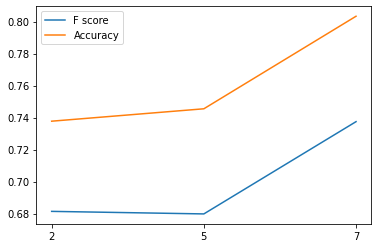

In [77]:
f_score_lst = []
accuracy_lst = []
days = [2, 5, 7]
days_str = ["2", "5", "7"]
for day in days:
    print("Day = {}".format(day))
    f_score, accuracy = avg_error_rate(N_days, day)
    f_score_lst.append(f_score)
    accuracy_lst.append(accuracy)
    print("\tMean accuracy: ", (accuracy*100).round(2), "%")
    print("\tMean f score: ", (f_score*100).round(2), "%")
plt.plot(days_str, f_score_lst, label = "F score")
plt.plot(days_str, accuracy_lst, label = "Accuracy")
plt.legend()

**Best result**

* Non standardized dataset
* n = 7 days
* validation set

In [78]:
nearest_metric(X_train_cv1_7, y_train_cv1_7, 
               X_val_cv1_7, y_val_cv1_7)

Accuracy of Nearest Mean method:  89.58 %
F1 score of Nearest Mean method:  93.83 %
Confusion Matrix: 
 [[ 5  3]
 [ 2 38]]


# Perceptron

## Training data

In [79]:
# Perceptron prediction function
def ppn_predict(n_iter, eta0, X_train, y_train, 
                X_test, y_test, random_state):
    
    # Create the perceptron instance
    ppn = Perceptron(n_iter_no_change = n_iter, 
                     eta0 = eta0, 
                     random_state = random_state)
    
    # fit the model using the standardized data
    ppn.fit(X_train, y_train)
    
    # make predictions
    y_pred = ppn.predict(X_test)
    
    accuracy_percp = accuracy_score(y_test, y_pred)
    f1_sco_percp = f1_score(y_test, y_pred)
    
    print("Original Dataset: ")
    print("Accuracy of Perceptron method: ", 
          round(accuracy_percp * 10**2, 2), "%")
    print("F1 score of Perceptron method: ", 
          round(f1_sco_percp * 10**2, 2), "%")
    print("Confusion Matrix: \n", confusion_matrix(y_test, y_pred))
    return accuracy_percp, f1_sco_percp

## Non Standardized

**original**

In [80]:
# Set parameters
n_iter=40
eta0=0.1
random_state=0

# Implement the prediction function
ppn_predict(n_iter, eta0, X_train, 
            y_train, X_test, y_test, random_state)

Original Dataset: 
Accuracy of Perceptron method:  81.67 %
F1 score of Perceptron method:  71.79 %
Confusion Matrix: 
 [[35  2]
 [ 9 14]]


(0.8166666666666667, 0.717948717948718)

**n = 2**

In [81]:
# Set parameters
n_iter=40
eta0=0.1
random_state=0

# Implement the prediction function
ppn_predict(n_iter, eta0, X_train_exp_2, y_train_exp_2, 
            X_test_exp_2, y_test_exp_2, random_state)

Original Dataset: 
Accuracy of Perceptron method:  63.33 %
F1 score of Perceptron method:  67.65 %
Confusion Matrix: 
 [[15 22]
 [ 0 23]]


(0.6333333333333333, 0.676470588235294)

**n = 2 with Pearson feature reduction**

In [82]:
# Set parameters
n_iter=40
eta0=0.1
random_state=0

# Implement the prediction function
ppn_predict(n_iter, eta0, X_train_pear_2, y_train_pear_2, 
            X_test_pear_2, y_test_pear_2, random_state)

Original Dataset: 
Accuracy of Perceptron method:  70.0 %
F1 score of Perceptron method:  71.88 %
Confusion Matrix: 
 [[19 18]
 [ 0 23]]


(0.7, 0.71875)

**n = 5**

In [83]:
# Set parameters
n_iter=40
eta0=0.1
random_state=0

# Implement the prediction function
ppn_predict(n_iter, eta0, X_train_exp_5, y_train_exp_5, 
            X_test_exp_5, y_test_exp_5, random_state)

Original Dataset: 
Accuracy of Perceptron method:  85.0 %
F1 score of Perceptron method:  83.64 %
Confusion Matrix: 
 [[28  9]
 [ 0 23]]


(0.85, 0.8363636363636363)

**n = 5 with Pearson feature reduction**

In [84]:
# Set parameters
n_iter=40
eta0=0.1
random_state=0

# Implement the prediction function
ppn_predict(n_iter, eta0, X_train_pear_5, y_train_pear_5, 
            X_test_pear_5, y_test_pear_5, random_state)

Original Dataset: 
Accuracy of Perceptron method:  76.67 %
F1 score of Perceptron method:  58.82 %
Confusion Matrix: 
 [[36  1]
 [13 10]]


(0.7666666666666667, 0.5882352941176471)

**n = 7**

In [85]:
# Set parameters
n_iter=40
eta0=0.1
random_state=0

# Implement the prediction function
ppn_predict(n_iter, eta0, X_train_exp_7, y_train_exp_7, 
            X_test_exp_7, y_test_exp_7, random_state)

Original Dataset: 
Accuracy of Perceptron method:  86.67 %
F1 score of Perceptron method:  80.95 %
Confusion Matrix: 
 [[35  2]
 [ 6 17]]


(0.8666666666666667, 0.8095238095238095)

**n = 7 with Pearson feature reduction**

In [86]:
# Set parameters
n_iter=40
eta0=0.1
random_state=0

# Implement the prediction function
ppn_predict(n_iter, eta0, X_train_pear_7, y_train_pear_7, 
            X_test_pear_7, y_test_pear_7, random_state)

Original Dataset: 
Accuracy of Perceptron method:  80.0 %
F1 score of Perceptron method:  66.67 %
Confusion Matrix: 
 [[36  1]
 [11 12]]


(0.8, 0.6666666666666667)

## Standardized Data

In [87]:
# Set parameters
n_iter=40
eta0=0.1
random_state=0

# Implement the prediction function
ppn_predict(n_iter, eta0, X_train_std, y_train, 
            X_test_std, y_test, random_state)

Original Dataset: 
Accuracy of Perceptron method:  90.0 %
F1 score of Perceptron method:  86.36 %
Confusion Matrix: 
 [[35  2]
 [ 4 19]]


(0.9, 0.8636363636363636)

**n = 2**

In [88]:
# Set parameters
n_iter=40
eta0=0.1
random_state=0

# Implement the prediction function
ppn_predict(n_iter, eta0, X_train_exp_2_std, y_train_exp_2, 
            X_test_exp_2_std, y_test_exp_2, random_state)

Original Dataset: 
Accuracy of Perceptron method:  88.33 %
F1 score of Perceptron method:  85.71 %
Confusion Matrix: 
 [[32  5]
 [ 2 21]]


(0.8833333333333333, 0.8571428571428572)

**n = 2 with pearson variables**

In [89]:
# Set parameters
n_iter=40
eta0=0.1
random_state=0

# Implement the prediction function
ppn_predict(n_iter, eta0, X_train_pear_2_std, y_train_pear_2, 
            X_test_pear_2_std, y_test_pear_2, random_state)

Original Dataset: 
Accuracy of Perceptron method:  88.33 %
F1 score of Perceptron method:  83.72 %
Confusion Matrix: 
 [[35  2]
 [ 5 18]]


(0.8833333333333333, 0.8372093023255814)

**n = 5**

In [90]:
# Set parameters
n_iter=40
eta0=0.1
random_state=0

# Implement the prediction function
ppn_predict(n_iter, eta0, X_train_exp_5_std, y_train_exp_5, 
            X_test_exp_5_std,y_test_exp_5, random_state)

Original Dataset: 
Accuracy of Perceptron method:  90.0 %
F1 score of Perceptron method:  87.5 %
Confusion Matrix: 
 [[33  4]
 [ 2 21]]


(0.9, 0.8749999999999999)

**Pearson**

In [91]:
# Set parameters
n_iter=40
eta0=0.1
random_state=0

# Implement the prediction function
ppn_predict(n_iter, eta0, X_train_pear_5_std, y_train_pear_5, 
            X_test_pear_5_std, y_test_pear_5, random_state)

Original Dataset: 
Accuracy of Perceptron method:  90.0 %
F1 score of Perceptron method:  86.96 %
Confusion Matrix: 
 [[34  3]
 [ 3 20]]


(0.9, 0.8695652173913043)

**n = 7**

In [92]:
# Set parameters
n_iter=40
eta0=0.1
random_state=0

# Implement the prediction function
ppn_predict(n_iter, eta0, X_train_exp_7_std, y_train_exp_7, 
            X_test_exp_7_std, y_test_exp_7, random_state)

Original Dataset: 
Accuracy of Perceptron method:  90.0 %
F1 score of Perceptron method:  86.96 %
Confusion Matrix: 
 [[34  3]
 [ 3 20]]


(0.9, 0.8695652173913043)

**Pearson**

In [93]:
# Set parameters
n_iter=40
eta0=0.1
random_state=0

# Implement the prediction function
ppn_predict(n_iter, eta0, X_train_pear_7_std, y_train_pear_7, 
            X_test_pear_7_std, y_test_pear_7, random_state)

Original Dataset: 
Accuracy of Perceptron method:  81.67 %
F1 score of Perceptron method:  78.43 %
Confusion Matrix: 
 [[29  8]
 [ 3 20]]


(0.8166666666666667, 0.7843137254901961)

## Backward Selected feature

In [94]:
sbs_2 = SFS(Perceptron(n_iter_no_change = 40, 
                     eta0 = 0.1), 
          k_features='best', 
          forward=False, 
         floating=False,
         verbose=2, 
         scoring='accuracy')
sbs_2.fit(X_train_exp_2, y_train_exp_2, 
          custom_feature_names=train_exp_2.drop(columns = ["Classes", "Date"]).columns)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:    0.1s finished

[2022-05-03 19:33:30] Features: 24/1 -- score: 0.8073015873015874[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed:    0.1s finished

[2022-05-03 19:33:31] Features: 23/1 -- score: 0.8579365079365079[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  23 out of  23 | elapsed:    0.1s finished

[2022-05-03 19:33:31] Features: 22/1 -- score: 0.8301587301587301[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  

SequentialFeatureSelector(estimator=Perceptron(eta0=0.1, n_iter_no_change=40),
                          forward=False, k_features='best', scoring='accuracy',
                          verbose=2)

In [95]:
sbs_2.k_feature_names_ 

('ISI', 'max_Rain')

In [96]:
sbs_5 = SFS(Perceptron(n_iter_no_change = 40, 
                     eta0 = 0.1), 
          k_features='best', 
          forward=False, 
         floating=False,
         verbose=2, 
         scoring='accuracy')
sbs_5.fit(X_train_exp_5, y_train_exp_5, custom_feature_names=train_exp_5.drop(columns = ["Classes", "Date"]).columns)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:    0.1s finished

[2022-05-03 19:33:33] Features: 24/1 -- score: 0.8181818181818181[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed:    0.1s finished

[2022-05-03 19:33:33] Features: 23/1 -- score: 0.8479166666666667[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  23 out of  23 | elapsed:    0.1s finished

[2022-05-03 19:33:34] Features: 22/1 -- score: 0.8299242424242423[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  

SequentialFeatureSelector(estimator=Perceptron(eta0=0.1, n_iter_no_change=40),
                          forward=False, k_features='best', scoring='accuracy',
                          verbose=2)

In [97]:
Backward_features = sbs_5.k_feature_names_ 

In [98]:
sbs_7 = SFS(Perceptron(n_iter_no_change = 40, 
                     eta0 = 0.1), 
          k_features='best', 
          forward=False, 
         floating=False,
         verbose=2, 
         scoring='accuracy')
sbs_7.fit(X_train_exp_7, y_train_exp_7, 
        custom_feature_names=train_exp_7.drop(columns = ["Classes", "Date"]).columns)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:    0.1s finished

[2022-05-03 19:33:36] Features: 24/1 -- score: 0.8522177419354838[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed:    0.1s finished

[2022-05-03 19:33:36] Features: 23/1 -- score: 0.8264112903225806[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  23 out of  23 | elapsed:    0.1s finished

[2022-05-03 19:33:36] Features: 22/1 -- score: 0.8393145161290322[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  

SequentialFeatureSelector(estimator=Perceptron(eta0=0.1, n_iter_no_change=40),
                          forward=False, k_features='best', scoring='accuracy',
                          verbose=2)

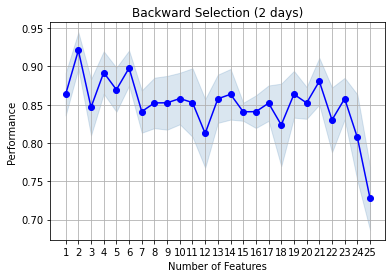

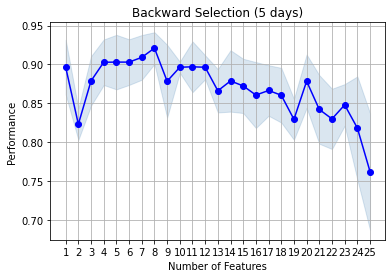

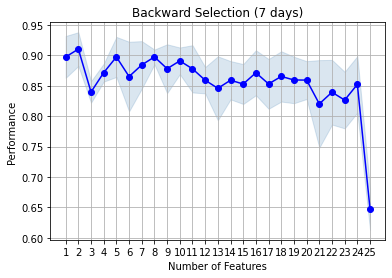

In [99]:
plot_sfs(sbs_2.get_metric_dict(), kind = "std_err")
plt.title("Backward Selection (2 days)")
plt.grid()
plt.savefig("back_select_2days.png")
plt.show()

plot_sfs(sbs_5.get_metric_dict(), kind = "std_err")
plt.title("Backward Selection (5 days)")
plt.grid()
plt.savefig("back_select_5days.png")
plt.show()

plot_sfs(sbs_7.get_metric_dict(), kind = "std_err")
plt.title("Backward Selection (7 days)")
plt.grid()
plt.savefig("back_select_7days.png")
plt.show()

**Best Result**

In [100]:
Backward_features = list(Backward_features)

In [101]:
X_train_best_back_pcpt = train_cv_1_5days[Backward_features].to_numpy()
y_train_best_back_pcpt = train_cv_1_5days["Classes"].to_numpy()
X_val_best_back_pcpt = valid_cv_1_5days[Backward_features].to_numpy()
y_val_best_back_pcpt = valid_cv_1_5days["Classes"].to_numpy()

In [102]:
# Set parameters
n_iter=40
eta0=0.1
random_state=0

# Implement the prediction function
ppn_predict(n_iter, eta0, X_train_best_back_pcpt, y_train_best_back_pcpt, 
            X_val_best_back_pcpt, y_val_best_back_pcpt, random_state)

Original Dataset: 
Accuracy of Perceptron method:  92.31 %
F1 score of Perceptron method:  95.65 %
Confusion Matrix: 
 [[ 4  4]
 [ 0 44]]


(0.9230769230769231, 0.9565217391304348)

# SVM

## Training Data

In [103]:
def svm(X_tr, y_tr, X_te, y_te, penalty):

    # Initialize the model
    SVM_Model = SVC(gamma = 'scale', random_state = 0, C = penalty)
    SVM_Model.fit(X_tr, y_tr)
    SVM_pred = SVM_Model.predict(X_te)
    print("Accuracy of SVM method: ", 
          (accuracy_score(y_te, SVM_pred)*100).round(2), "%")
    print("F1 score of SVM method: ", 
          round(f1_score(y_te, SVM_pred) * 10**2, 2), "%")
    print("Confusion matrix of  SVM method: ", 
          confusion_matrix(y_te, SVM_pred))

## Non Standardized

**Original**

In [104]:
svm(X_train, y_train, X_test, y_test, 1)

Accuracy of SVM method:  81.67 %
F1 score of SVM method:  79.25 %
Confusion matrix of  SVM method:  [[28  9]
 [ 2 21]]


In [105]:
svm(X_train, y_train, X_test, y_test, 2)

Accuracy of SVM method:  83.33 %
F1 score of SVM method:  80.0 %
Confusion matrix of  SVM method:  [[30  7]
 [ 3 20]]


**n = 2**

In [106]:
svm(X_train_exp_2, y_train_exp_2, X_test_exp_2, y_test_exp_2, 1)

Accuracy of SVM method:  83.33 %
F1 score of SVM method:  80.77 %
Confusion matrix of  SVM method:  [[29  8]
 [ 2 21]]


In [107]:
svm(X_train_exp_2, y_train_exp_2, X_test_exp_2, y_test_exp_2, 2)

Accuracy of SVM method:  85.0 %
F1 score of SVM method:  82.35 %
Confusion matrix of  SVM method:  [[30  7]
 [ 2 21]]


In [108]:
svm(X_train_exp_2, y_train_exp_2, X_test_exp_2, y_test_exp_2, 3)

Accuracy of SVM method:  83.33 %
F1 score of SVM method:  80.77 %
Confusion matrix of  SVM method:  [[29  8]
 [ 2 21]]


**n = 5**

In [109]:
svm(X_train_exp_5, y_train_exp_5, X_test_exp_5, y_test_exp_5, 1)

Accuracy of SVM method:  81.67 %
F1 score of SVM method:  78.43 %
Confusion matrix of  SVM method:  [[29  8]
 [ 3 20]]


In [110]:
svm(X_train_exp_5, y_train_exp_5, X_test_exp_5, y_test_exp_5, 2)

Accuracy of SVM method:  85.0 %
F1 score of SVM method:  82.35 %
Confusion matrix of  SVM method:  [[30  7]
 [ 2 21]]


In [111]:
svm(X_train_exp_5, y_train_exp_5, X_test_exp_5, y_test_exp_5, 3)

Accuracy of SVM method:  85.0 %
F1 score of SVM method:  82.35 %
Confusion matrix of  SVM method:  [[30  7]
 [ 2 21]]


**n = 7**

In [112]:
svm(X_train_exp_7, y_train_exp_7, X_test_exp_7, y_test_exp_7, 1)

Accuracy of SVM method:  80.0 %
F1 score of SVM method:  76.0 %
Confusion matrix of  SVM method:  [[29  8]
 [ 4 19]]


In [113]:
svm(X_train_exp_7, y_train_exp_7, X_test_exp_7, y_test_exp_7, 2)

Accuracy of SVM method:  78.33 %
F1 score of SVM method:  74.51 %
Confusion matrix of  SVM method:  [[28  9]
 [ 4 19]]


## Standardized Data

**Original**

In [114]:
svm(X_train_std, y_train, X_test_std, y_test, 1)

Accuracy of SVM method:  88.33 %
F1 score of SVM method:  83.72 %
Confusion matrix of  SVM method:  [[35  2]
 [ 5 18]]


In [115]:
svm(X_train_std, y_train, X_test_std, y_test, 2)

Accuracy of SVM method:  86.67 %
F1 score of SVM method:  81.82 %
Confusion matrix of  SVM method:  [[34  3]
 [ 5 18]]


**n = 2**

In [116]:
svm(X_train_exp_2_std, y_train_exp_2, 
    X_test_exp_2_std, y_test_exp_2, 1)

Accuracy of SVM method:  80.0 %
F1 score of SVM method:  73.91 %
Confusion matrix of  SVM method:  [[31  6]
 [ 6 17]]


In [117]:
svm(X_train_exp_2_std, y_train_exp_2, 
    X_test_exp_2_std, y_test_exp_2, 2)

Accuracy of SVM method:  78.33 %
F1 score of SVM method:  71.11 %
Confusion matrix of  SVM method:  [[31  6]
 [ 7 16]]


**n = 5**

In [118]:
svm(X_train_exp_5_std, y_train_exp_5, 
    X_test_exp_5_std, y_test_exp_5, 1)

Accuracy of SVM method:  83.33 %
F1 score of SVM method:  77.27 %
Confusion matrix of  SVM method:  [[33  4]
 [ 6 17]]


In [119]:
svm(X_train_exp_5_std, y_train_exp_5, 
    X_test_exp_5_std, y_test_exp_5, 2)

Accuracy of SVM method:  85.0 %
F1 score of SVM method:  79.07 %
Confusion matrix of  SVM method:  [[34  3]
 [ 6 17]]


**n = 7**

In [120]:
svm(X_train_exp_7_std, y_train_exp_7, 
    X_test_exp_7_std, y_test_exp_7, 1)

Accuracy of SVM method:  85.0 %
F1 score of SVM method:  80.0 %
Confusion matrix of  SVM method:  [[33  4]
 [ 5 18]]


In [121]:
svm(X_train_exp_7_std, y_train_exp_7, 
    X_test_exp_7_std, y_test_exp_7, 2)

Accuracy of SVM method:  85.0 %
F1 score of SVM method:  80.85 %
Confusion matrix of  SVM method:  [[32  5]
 [ 4 19]]


## Best Result

**On validation set**

In [122]:
origin_features = ['Temperature', 'RH', 'Ws', 
                   'Rain', 'FFMC', 'DMC', 'DC', 'ISI', 'BUI']

In [123]:
X_train_best_org_SVM = train_cv_1_2days[origin_features].to_numpy()
y_train_best_org_SVM = train_cv_1_2days["Classes"].to_numpy()
X_val_best_org_SVM = valid_cv_1_2days[origin_features].to_numpy()
y_val_best_org_SVM = valid_cv_1_2days["Classes"].to_numpy()

In [124]:
scaler = StandardScaler().fit(X_train_best_org_SVM)
X_train_best_org_SVM_scaled = scaler.transform(X_train_best_org_SVM)
X_val_best_org_SVM_scaled = scaler.transform(X_val_best_org_SVM)

In [125]:
svm(X_train_best_org_SVM_scaled, y_train_best_org_SVM, 
    X_val_best_org_SVM_scaled, y_val_best_org_SVM, 1)

Accuracy of SVM method:  93.1 %
F1 score of SVM method:  95.92 %
Confusion matrix of  SVM method:  [[ 7  2]
 [ 2 47]]


**On test set**

In [126]:
svm(X_train_std, y_train, X_test_std, y_test, 1)

Accuracy of SVM method:  88.33 %
F1 score of SVM method:  83.72 %
Confusion matrix of  SVM method:  [[35  2]
 [ 5 18]]


In [127]:
def ANN(X_tr, y_tr, X_te, y_te, layer_size, n_iter):
    if n_iter == None:
        max_inter = 200
    ann = MLPClassifier(solver='lbfgs', alpha=0.0001, 
                        hidden_layer_sizes=layer_size, 
                        random_state=1, max_iter=n_iter)
    
    ann.fit(X_tr, y_tr)
    y_pre = ann.predict(X_te)
    print("Accuracy of ANN method: ", 
          (accuracy_score(y_te, y_pre)*100).round(2), "%")
    print("F1 score of ANN method: ", 
          round(f1_score(y_te, y_pre) * 10**2, 2), "%")
    print("Confusion Matrix of ANN method: ", 
          confusion_matrix(y_te, y_pre))

# ANN

## Non Standardized

**Original**

In [128]:
ANN(X_train, y_train, X_test, y_test, (5, 3, ), 500)

Accuracy of ANN method:  86.67 %
F1 score of ANN method:  80.95 %
Confusion Matrix of ANN method:  [[35  2]
 [ 6 17]]


In [129]:
ANN(X_train, y_train, X_test, y_test, (7, 4, ), 250)

Accuracy of ANN method:  85.0 %
F1 score of ANN method:  80.0 %
Confusion Matrix of ANN method:  [[33  4]
 [ 5 18]]


C:\Users\youun\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


**n = 2**

In [130]:
ANN(X_train_exp_2, y_train_exp_2, 
    X_test_exp_2, y_test_exp_2, (2, 3, ), 400)

Accuracy of ANN method:  91.67 %
F1 score of ANN method:  88.89 %
Confusion Matrix of ANN method:  [[35  2]
 [ 3 20]]


C:\Users\youun\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


In [131]:
ANN(X_train_exp_2, y_train_exp_2, 
    X_test_exp_2, y_test_exp_2, (3, 4, ), 200)

Accuracy of ANN method:  80.0 %
F1 score of ANN method:  76.92 %
Confusion Matrix of ANN method:  [[28  9]
 [ 3 20]]


In [132]:
ANN(X_train_exp_2, y_train_exp_2, 
    X_test_exp_2, y_test_exp_2, (4, 4, ), 200)

Accuracy of ANN method:  88.33 %
F1 score of ANN method:  83.72 %
Confusion Matrix of ANN method:  [[35  2]
 [ 5 18]]


**n = 5**

In [133]:
ANN(X_train_exp_5, y_train_exp_5, 
    X_test_exp_5, y_test_exp_5, (2, 3), 200)

Accuracy of ANN method:  86.67 %
F1 score of ANN method:  82.61 %
Confusion Matrix of ANN method:  [[33  4]
 [ 4 19]]


In [134]:
ANN(X_train_exp_5, y_train_exp_5, 
    X_test_exp_5, y_test_exp_5, (3, 4), 200)

Accuracy of ANN method:  80.0 %
F1 score of ANN method:  77.78 %
Confusion Matrix of ANN method:  [[27 10]
 [ 2 21]]


In [135]:
ANN(X_train_exp_5, y_train_exp_5, 
    X_test_exp_5, y_test_exp_5, (4, 4), 200)

Accuracy of ANN method:  90.0 %
F1 score of ANN method:  86.36 %
Confusion Matrix of ANN method:  [[35  2]
 [ 4 19]]


**n = 7**

In [136]:
ANN(X_train_exp_7, y_train_exp_7, 
    X_test_exp_7, y_test_exp_7, (2, 3), 200)

Accuracy of ANN method:  85.0 %
F1 score of ANN method:  79.07 %
Confusion Matrix of ANN method:  [[34  3]
 [ 6 17]]


In [137]:
ANN(X_train_exp_7, y_train_exp_7, 
    X_test_exp_7, y_test_exp_7, (3, 4), 200)

Accuracy of ANN method:  81.67 %
F1 score of ANN method:  76.6 %
Confusion Matrix of ANN method:  [[31  6]
 [ 5 18]]


In [138]:
ANN(X_train_exp_7, y_train_exp_7, 
    X_test_exp_7, y_test_exp_7, (4, 4), 200)

Accuracy of ANN method:  86.67 %
F1 score of ANN method:  82.61 %
Confusion Matrix of ANN method:  [[33  4]
 [ 4 19]]


## Standardized Data

**Original**

In [139]:
ANN(X_train_std, y_train, 
    X_test_std, y_test, (2, 3), 200)

Accuracy of ANN method:  90.0 %
F1 score of ANN method:  86.96 %
Confusion Matrix of ANN method:  [[34  3]
 [ 3 20]]


In [140]:
ANN(X_train_std, y_train, 
    X_test_std, y_test, (3, 4), 200)

Accuracy of ANN method:  90.0 %
F1 score of ANN method:  86.36 %
Confusion Matrix of ANN method:  [[35  2]
 [ 4 19]]


C:\Users\youun\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


In [141]:
ANN(X_train_std, y_train, 
    X_test_std, y_test, (4, 4), 200)

Accuracy of ANN method:  88.33 %
F1 score of ANN method:  83.72 %
Confusion Matrix of ANN method:  [[35  2]
 [ 5 18]]


**n = 2**

In [142]:
ANN(X_train_exp_2_std, y_train_exp_2, 
    X_test_exp_2_std, y_test_exp_2, (2, 3), 200)

Accuracy of ANN method:  86.67 %
F1 score of ANN method:  80.0 %
Confusion Matrix of ANN method:  [[36  1]
 [ 7 16]]


In [143]:
ANN(X_train_exp_2_std, y_train_exp_2, 
    X_test_exp_2_std, y_test_exp_2, (3, 4), 200)

Accuracy of ANN method:  81.67 %
F1 score of ANN method:  75.56 %
Confusion Matrix of ANN method:  [[32  5]
 [ 6 17]]


In [144]:
ANN(X_train_exp_2_std, y_train_exp_2, 
    X_test_exp_2_std, y_test_exp_2, (4, 4), 400)

Accuracy of ANN method:  83.33 %
F1 score of ANN method:  78.26 %
Confusion Matrix of ANN method:  [[32  5]
 [ 5 18]]


**n = 5**

In [145]:
ANN(X_train_exp_5_std, y_train_exp_5, 
    X_test_exp_5_std, y_test_exp_5, (2, 3), 200)

Accuracy of ANN method:  83.33 %
F1 score of ANN method:  75.0 %
Confusion Matrix of ANN method:  [[35  2]
 [ 8 15]]


In [146]:
ANN(X_train_exp_5_std, y_train_exp_5, 
    X_test_exp_5_std, y_test_exp_5, (3, 4), 200)

Accuracy of ANN method:  81.67 %
F1 score of ANN method:  74.42 %
Confusion Matrix of ANN method:  [[33  4]
 [ 7 16]]


In [147]:
ANN(X_train_exp_5_std, y_train_exp_5, 
    X_test_exp_5_std, y_test_exp_5, (4, 4), 200)

Accuracy of ANN method:  80.0 %
F1 score of ANN method:  75.0 %
Confusion Matrix of ANN method:  [[30  7]
 [ 5 18]]


**n = 7**

In [148]:
ANN(X_train_exp_7_std, y_train_exp_7, 
    X_test_exp_7_std, y_test_exp_7, (2, 3), 200)

Accuracy of ANN method:  81.67 %
F1 score of ANN method:  73.17 %
Confusion Matrix of ANN method:  [[34  3]
 [ 8 15]]


In [149]:
ANN(X_train_exp_7_std, y_train_exp_7, 
    X_test_exp_7_std, y_test_exp_7, (3, 4), 200)

Accuracy of ANN method:  88.33 %
F1 score of ANN method:  84.44 %
Confusion Matrix of ANN method:  [[34  3]
 [ 4 19]]


In [150]:
ANN(X_train_exp_7_std, y_train_exp_7, 
    X_test_exp_7_std, y_test_exp_7, (4, 4), 200)

Accuracy of ANN method:  81.67 %
F1 score of ANN method:  77.55 %
Confusion Matrix of ANN method:  [[30  7]
 [ 4 19]]


## Best Result

In [151]:
scaler = StandardScaler().fit(X_train_cv1_2)
X_train_scaled = scaler.transform(X_train_cv1_2)
X_val_scaled = scaler.transform(X_val_cv1_2)

In [152]:
ANN(X_train_scaled, y_train_cv1_2, 
    X_val_scaled, y_val_cv1_2, (2, 3), 500)

Accuracy of ANN method:  87.93 %
F1 score of ANN method:  92.78 %
Confusion Matrix of ANN method:  [[ 6  3]
 [ 4 45]]
